In [1]:
### 1. Load and process data ###
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Initialization
file_path = '/kaggle/input/5min-averages/cleaned_5min_averages_all.csv'
#main_folder_path = '/content/30min_averages_all.csv'
seq_length = 30
forecast_horizon = 1
weights = torch.tensor([1.0])
num_epochs = 5
columns_to_scale = ['Temperature' ,'Humidity','Pressure','oxidised', 'proximity', 'Reduced', 'light', 'NH3'] # selected variables
#columns_to_scale = ['proximity']
lambda_l2 = 0.00000

In [2]:
train_ieq, train_y = [], []
val_ieq, val_y = [], []
test_ieq, test_y = [], []

# Data preprocessing
def create_sequences(data, seq_length, forecast_horizon):
    sequences = []
    for i in range(len(data) - seq_length - forecast_horizon + 1):
        sequences.append(data[i:(i + seq_length + forecast_horizon)])
    return np.array(sequences)

for i in range(1, 7):
    # Load IEQ data
    file_path = '/kaggle/input/5min-averages/cleaned_5min_averages_all.csv'
    data = pd.read_csv(file_path)

    # Normalize the IEQ data excluding 'Comfort Level' and 'Health Level' columns
    scaler_ieq = MinMaxScaler(feature_range=(0, 1))
    #scaler_ieq = StandardScaler()

    scaled_values = scaler_ieq.fit_transform(data[columns_to_scale])

    # Convert scaled values to DataFrame
    scaled_ieq = pd.DataFrame(scaled_values, columns=columns_to_scale, index=data.index)

    # Use the full duration of the scaled_ieq data
    scaled_ieq = scaled_ieq.values

    # Create 3D sequence data from each type of features
    ieq_sequences = create_sequences(scaled_ieq, seq_length, forecast_horizon)

    X_temp_ieq, X_test_ieq_session, y_temp, y_test_session = train_test_split(
        ieq_sequences[:, :-forecast_horizon, :], ieq_sequences[:, -forecast_horizon:, :10], test_size=0.1, shuffle=True)

    X_train_ieq_session, X_val_ieq_session, y_train_session, y_val_session = train_test_split(
        X_temp_ieq, y_temp, test_size=0.1111, shuffle=True)

    # Append session data to respective list
    train_ieq.append(X_train_ieq_session)
    train_y.append(y_train_session)

    val_ieq.append(X_val_ieq_session)
    val_y.append(y_val_session)

    test_ieq.append(X_test_ieq_session)
    test_y.append(y_test_session)

# Concatenate all the session data
X_train_ieq = np.concatenate(train_ieq, axis=0)
y_train = np.concatenate(train_y, axis=0)

X_val_ieq = np.concatenate(val_ieq, axis=0)
y_val = np.concatenate(val_y, axis=0)

X_test_ieq = np.concatenate(test_ieq, axis=0)
y_test = np.concatenate(test_y, axis=0)

# Create DataLoaders
batch_size = 256
train_data = TensorDataset(torch.tensor(X_train_ieq).float(), torch.tensor(y_train).float())
val_data = TensorDataset(torch.tensor(X_val_ieq).float(), torch.tensor(y_val).float())
test_data = TensorDataset(torch.tensor(X_test_ieq).float(), torch.tensor(y_test).float())

train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [3]:
### 2. Define Model ###
# Define the SingleModalModel
class SingleModalModel(nn.Module):
    def __init__(self, input_dim_ieq, hidden_dim, num_layers, dropout_rate, n_out):
        super(SingleModalModel, self).__init__()

        self.lstm1 = nn.LSTM(input_dim_ieq, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # Fully connected layer for each LSTM
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.fc2 = nn.Linear(hidden_dim, n_out)  # Fully connected layer for the final LSTM layer

    def forward(self, x_ieq):
        lstm_out1, _ = self.lstm1(x_ieq)
        lstm_out1 = lstm_out1[:, -1, :]
        fc_out1 = F.relu(self.fc1(lstm_out1))
        fc_out1 = self.dropout(fc_out1)
        x = self.fc2(fc_out1)
        return x

Epoch 1/5, Train Loss: 0.00547195306905929, Validation Loss: 0.002235700292546155
Epoch 2/5, Train Loss: 0.002955709176637442, Validation Loss: 0.00213764807773507
Epoch 3/5, Train Loss: 0.002650718490262511, Validation Loss: 0.002041519927294878
Epoch 4/5, Train Loss: 0.002467654522589514, Validation Loss: 0.002016988330717636
Epoch 5/5, Train Loss: 0.002360677585439695, Validation Loss: 0.0020192581432534377


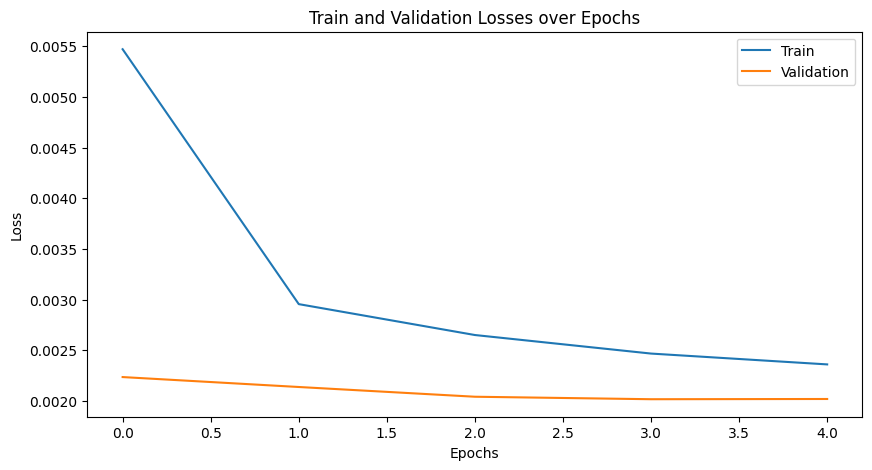

Execution time: 414.49101209640503 seconds


In [4]:
### 3. Train model ###
import time
# Start the timer
start_time = time.time()

# Model Configuration
input_dim_ieq = X_train_ieq.shape[-1]

# Hyperparameters
hidden_dim = 256 #32
num_layers = 2   #1
dropout_rate = 0.5
n_out = len(columns_to_scale)

model = SingleModalModel(input_dim_ieq, hidden_dim, num_layers, dropout_rate, n_out)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)

def weighted_mse_loss(input, target, weight):
    # Ensure all tensors are of the same type and shape
    input = input.float()
    target = target.float()
    weight = weight.float()

    return ((weight * (input - target))** 2).mean()

def weighted_mae_loss(input, target, weight):
    # Ensure all tensors are of the same type and shape
    input = input.float()
    target = target.float()
    weight = weight.float()

    return (weight * torch.abs(input - target)).mean()

def l2_regularization(model, lambda_l2):
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    return lambda_l2 * l2_norm

#weights = torch.tensor([1,1,1,4,10,1,10,1,1]).to(device)
weights = torch.tensor([1.0]*len(columns_to_scale)).to(device)

train_losses = []
val_losses = []
# Training loops
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for ieq_inputs, targets in train_loader:
        ieq_inputs, targets = ieq_inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(ieq_inputs)

        l2_loss = l2_regularization(model, lambda_l2)
        targets = targets.squeeze(1)
        loss = weighted_mse_loss(outputs.to(device), targets, weights) + l2_loss

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * ieq_inputs.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for ieq_inputs, targets in val_loader:
            ieq_inputs, targets = ieq_inputs.to(device), targets.to(device)

            outputs = model(ieq_inputs)
            l2_loss = l2_regularization(model, lambda_l2)
            targets = targets.squeeze(1) ### change 1
            loss = weighted_mse_loss(outputs.to(device), targets, weights) + l2_loss

            val_loss += loss.item() * ieq_inputs.size(0)

    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

# Plotting the training and validation losses
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.title("Train and Validation Losses over Epochs")
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Stop the timer
end_time = time.time()
# Calculate the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [5]:
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import numpy as np

# Function to check if the error exceeds the threshold
def count_threshold_exceedances(y_actual, y_predicted, threshold=10):
    """
    Counts the total number of predictions that exceed the error threshold.
    """
    true_count = 0
    false_count = 0
    
    for actual, predicted in zip(y_actual, y_predicted):
        percentage_error = np.abs((actual - predicted) / actual) * 100 if actual != 0 else np.inf
        if percentage_error > threshold:
            true_count += 1
        else:
            false_count += 1
            
    return true_count, false_count

# Start the timer
start_time = time.time()

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store overall and parameter-specific predictions and actuals
overall_predictions = []
overall_actuals = []

# Variable initialization for parameter-specific predictions and actuals
num_parameters = None
parameter_predictions = []
parameter_actuals = []

with torch.no_grad():
    for ieq_inputs, targets in test_loader:
        ieq_inputs, targets = ieq_inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(ieq_inputs)
        
        # Remove the extra dimension from targets if needed
        if targets.ndim == 3 and targets.shape[1] == 1:
            targets = targets.squeeze(1)

        # Convert outputs and targets to numpy arrays for easier manipulation
        predictions = outputs.detach().cpu().numpy()
        actuals = targets.detach().cpu().numpy()

        # Collect overall predictions and actuals
        overall_predictions.append(outputs.cpu().numpy())
        overall_actuals.append(targets.cpu().numpy())

        # Initialize parameter-specific containers based on output shape
        if num_parameters is None:
            num_parameters = outputs.shape[1] if outputs.ndim > 1 else 1
            parameter_predictions = [[] for _ in range(num_parameters)]
            parameter_actuals = [[] for _ in range(num_parameters)]
        
        # Collect parameter-specific predictions and actuals
        for i in range(num_parameters):
            parameter_predictions[i].append(outputs[:, i].cpu().numpy())
            parameter_actuals[i].append(targets[:, i].cpu().numpy())

# Concatenate overall predictions and actuals
overall_predictions = np.concatenate(overall_predictions, axis=0).reshape(-1)
overall_actuals = np.concatenate(overall_actuals, axis=0).reshape(-1)

# Compute overall metrics
overall_mse = mean_squared_error(overall_actuals, overall_predictions)
overall_rmse = np.sqrt(overall_mse)
overall_mae = mean_absolute_error(overall_actuals, overall_predictions)
overall_r2 = r2_score(overall_actuals, overall_predictions)

# Print overall metrics
print(f'Overall Test MSE: {overall_mse:.6f}')
print(f'Overall Test RMSE: {overall_rmse:.6f}')
print(f'Overall Test MAE: {overall_mae:.6f}')
print(f'Overall Test R^2 Score: {overall_r2:.6f}')
print(f"Execution time: {time.time() - start_time:.6f} seconds")

# Compute and print metrics for each parameter
for i in range(num_parameters):
    param_predictions = np.concatenate(parameter_predictions[i], axis=0).reshape(-1)
    param_actuals = np.concatenate(parameter_actuals[i], axis=0).reshape(-1)

    # Count true and false predictions for the parameter
    true_count, false_count = count_threshold_exceedances(param_actuals, param_predictions)
    
    # Compute parameter-specific metrics
    param_mse = mean_squared_error(param_actuals, param_predictions)
    param_rmse = np.sqrt(param_mse)
    param_mae = mean_absolute_error(param_actuals, param_predictions)
    param_r2 = r2_score(param_actuals, param_predictions)

    # Print metrics for the parameter
    print(f'Parameter {i + 1} Test MSE: {param_mse:.6f}')
    print(f'Parameter {i + 1} Test RMSE: {param_rmse:.6f}')
    print(f'Parameter {i + 1} Test MAE: {param_mae:.6f}')
    print(f'Parameter {i + 1} Test R^2 Score: {param_r2:.6f}')
    print(f"Parameter {i + 1} - Total True (exceeds 10% threshold): {true_count}")
    print(f"Parameter {i + 1} - Total False (within 10% threshold): {false_count}")
    print("-" * 30)
    print(f"Execution time: {time.time() - start_time:.6f} seconds")


Overall Test MSE: 0.002034
Overall Test RMSE: 0.045105
Overall Test MAE: 0.020030
Overall Test R^2 Score: 0.964017
Execution time: 4.098195 seconds
Parameter 1 Test MSE: 0.000428
Parameter 1 Test RMSE: 0.020692
Parameter 1 Test MAE: 0.014685
Parameter 1 Test R^2 Score: 0.965975
Parameter 1 - Total True (exceeds 10% threshold): 2920
Parameter 1 - Total False (within 10% threshold): 86366
------------------------------
Execution time: 4.496679 seconds
Parameter 2 Test MSE: 0.000335
Parameter 2 Test RMSE: 0.018290
Parameter 2 Test MAE: 0.013513
Parameter 2 Test R^2 Score: 0.970290
Parameter 2 - Total True (exceeds 10% threshold): 8286
Parameter 2 - Total False (within 10% threshold): 81000
------------------------------
Execution time: 4.896791 seconds
Parameter 3 Test MSE: 0.013774
Parameter 3 Test RMSE: 0.117364
Parameter 3 Test MAE: 0.092292
Parameter 3 Test R^2 Score: 0.199871
Parameter 3 - Total True (exceeds 10% threshold): 55651
Parameter 3 - Total False (within 10% threshold): 336

# Plot results

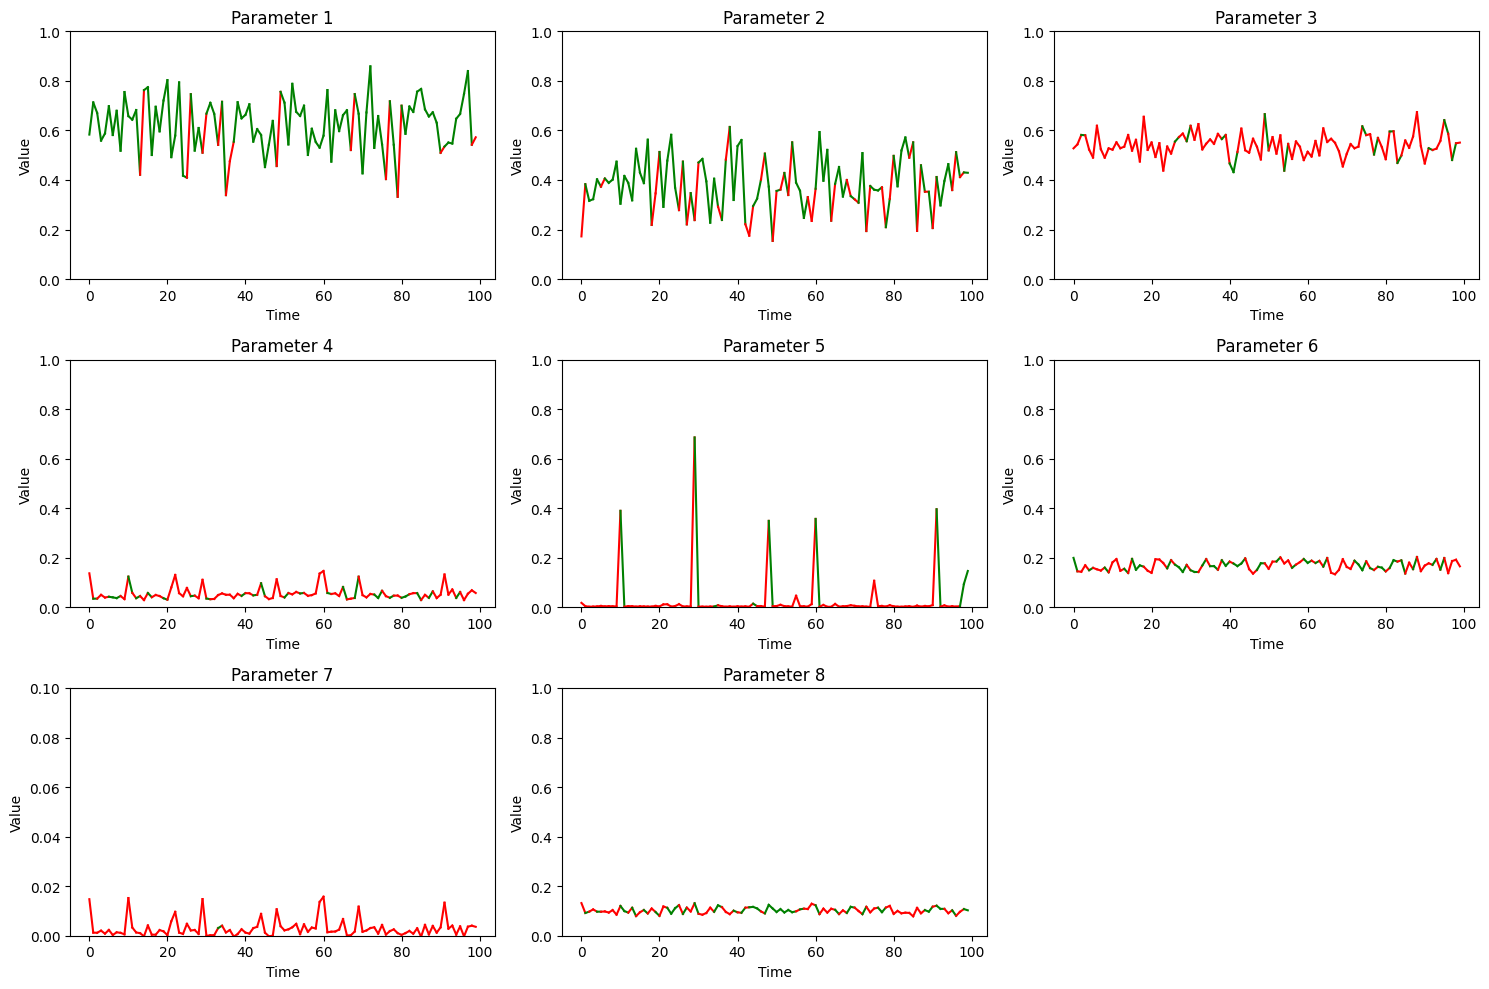

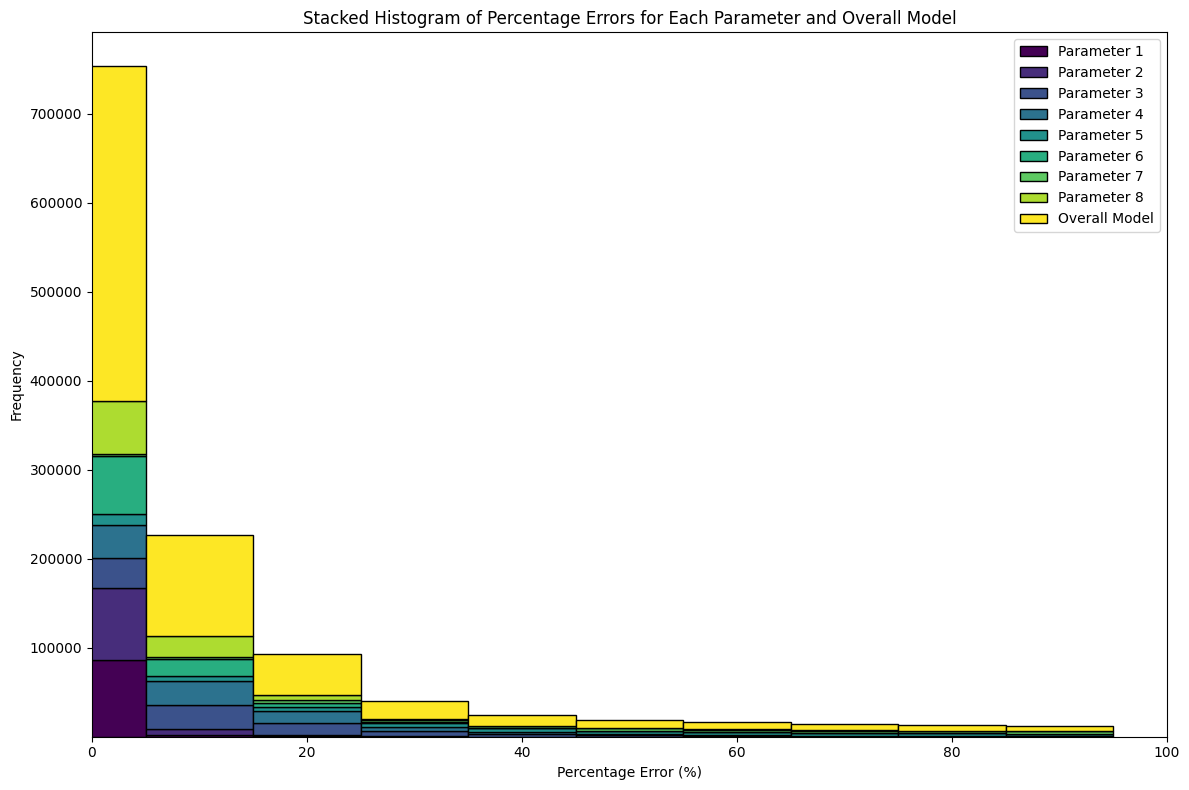

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assume you already have your model loaded and set up, as well as y_test

# Generate predictions using the model and store them in plot_predictions
with torch.no_grad():
    model.eval()
    predictions = []
    for ieq_inputs, _ in test_loader:
        ieq_inputs = ieq_inputs.to(device)
        outputs = model(ieq_inputs)
        predictions.append(outputs.detach().cpu().numpy())

# Concatenate predictions to form a single array
plot_predictions = np.concatenate(predictions, axis=0)

# Define the 5% threshold function
def within_5_percent(actual, predicted):
    return np.abs(actual - predicted) <= 0.05 * actual

# Function to plot the line with segments colored differently
def plot_with_color(y_actual, y_predicted):
    for j in range(len(y_predicted) - 1):
        # Check if within 5% for the current segment
        color = 'green' if within_5_percent(y_actual[j], y_predicted[j]) else 'red'
        plt.plot([j, j+1], [y_predicted[j], y_predicted[j+1]], color=color)

# Plotting the predicted results for each parameter
plt.figure(figsize=(15, 10))

# Iterate over each parameter
for i in range(len(columns_to_scale)):
    plt.subplot(3, 3, i+1)
    plot_with_color(y_test[:100, :, i].flatten(), plot_predictions[:100, i])
    
    if i == 6 or i == 8:
        plt.ylim(0, 0.1)
    else:
        plt.ylim(0, 1)

    plt.title(f'Parameter {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

# Function to calculate percentage error
def percentage_error(actual, predicted):
    with np.errstate(divide='ignore', invalid='ignore'):
        percentage_errors = np.abs((actual - predicted) / actual) * 100
        percentage_errors[np.isnan(percentage_errors)] = 0
    return percentage_errors

# Bins for the histogram (0-10%, 10-20%, ..., 90-100%)
bins = np.arange(0, 110, 10)

# Calculate percentage errors for overall predictions
overall_percentage_errors = percentage_error(overall_actuals, overall_predictions)

# Generate histogram data for the overall model
overall_hist, _ = np.histogram(overall_percentage_errors, bins=bins)

# Prepare a dictionary to store histogram data for each parameter
param_hist_data = {}

for i in range(num_parameters):
    param_predictions = np.concatenate(parameter_predictions[i], axis=0).reshape(-1)
    param_actuals = np.concatenate(parameter_actuals[i], axis=0).reshape(-1)
    param_percentage_errors = percentage_error(param_actuals, param_predictions)
    param_hist, _ = np.histogram(param_percentage_errors, bins=bins)
    param_hist_data[f'Parameter {i+1}'] = param_hist

# Convert the dictionary data into a list of arrays for stacking
param_hist_values = np.array([param_hist_data[f'Parameter {i+1}'] for i in range(num_parameters)])

# Add overall model as an additional row to the stacked values
param_hist_values = np.vstack([param_hist_values, overall_hist])

# Plotting the stacked histogram
plt.figure(figsize=(12, 8))

# Stacked bar plot for each parameter and overall model
colors = plt.cm.viridis(np.linspace(0, 1, num_parameters + 1))
for i in range(num_parameters + 1):
    if i < num_parameters:
        label = f'Parameter {i+1}'
    else:
        label = 'Overall Model'
    plt.bar(
        bins[:-1], param_hist_values[i], width=10, 
        bottom=np.sum(param_hist_values[:i], axis=0), 
        label=label, edgecolor='black', color=colors[i]
    )

plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Percentage Errors for Each Parameter and Overall Model')
plt.legend()
plt.xlim(0, 100)  # Set x-axis limits to 0-100
plt.tight_layout()
plt.show()
